# ARPA Weather Station Data
This notebook is used for:
1) testing ARPA API functionalities
2) testing functions to be implemented in the plugin
3) testing libraries to be used and evaluate performances

First, it is necessary to get a token.
Go to Open Data Lombardia website (https://dati.lombardia.it/). Subscribe to the website and go to your profile settings. <br>
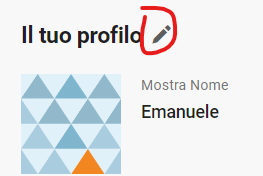 <br>
Modify your profile and open the "Opzioni per lo sviluppatore" tab. Create a new App Token to be used.


Useful notebook for Sodapy: https://github.com/xmunoz/sodapy/blob/master/examples/soql_queries.py

In [1]:
arpa_token = "riTLzYVRVdDaQtUkxDDaHRgJi" 

In [2]:
print(arpa_token)

riTLzYVRVdDaQtUkxDDaHRgJi


Pandas va installato anche se si installa prima Dask

In [3]:
from sodapy import Socrata
import pandas as pd
from datetime import datetime, timedelta
import requests
from io import BytesIO
from zipfile import ZipFile
import os
import time
import dask.dataframe as dd

Function to create a client session with the API using the token:

In [4]:
def connect_ARPA_api(token):
    """
    Function to connect to ARPA API.

        Parameters:
            - token (str): the ARPA token obtained from Open Data Lombardia website

        Returns:
            - client: client session
            
    """
    client = Socrata("www.dati.lombardia.it", app_token=token)

    return client

Import the code of the dataset. In this case "nf78-nj6b" is related to ARPA stations information containing:
1) sensors id
2) sensor type
3) unit
4) stations id
5) stations names
...

In [5]:
stationsId = "nf78-nj6b" # Select meteo stations dataset containing positions and information about sensors
client = connect_ARPA_api(arpa_token)
sensors_info = client.get_all(stationsId)

Create sensors dataframe:

In [6]:
sensors_df = pd.DataFrame(sensors_info)
sensors_df

,idsensore,tipologia,unit_dimisura,idstazione,nomestazione,quota,provincia,datastart,storico,cgb_nord,cgb_est,lng,lat,location,:@computed_region_6hky_swhk,:@computed_region_ttgh_9sm5,datastop
0,10373,Precipitazione,mm,687,Ferno v.Di Dio,215,VA,2007-08-13T00:00:00.000,N,5051773,481053,8.756970445453431,45.61924377994763,"{'latitude': '45.61924377994763', 'longitude':...",1,1,NaN
1,10376,Precipitazione,mm,706,Lecco v.Sora,272,LC,2008-07-22T00:00:00.000,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",10,10,NaN
2,10377,Temperatura,°C,706,Lecco v.Sora,272,LC,2008-07-22T00:00:00.000,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",10,10,NaN
3,10381,Umidità Relativa,%,706,Lecco v.Sora,272,LC,2008-07-22T00:00:00.000,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",10,10,NaN
4,10382,Radiazione Globale,W/m²,706,Lecco v.Sora,272,LC,2008-07-31T00:00:00.000,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",10,10,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,9869,Umidità Relativa,%,672,Cornale v.Libertà,74,PV,2005-07-28T00:00:00.000,N,4987406,493238,8.914144599002409,45.04007657202963,"{'latitude': '45.04007657202963', 'longitude':...",7,7,NaN
1228,9933,Precipitazione,mm,677,Cremona Via Fatebenefratelli,43,CR,2006-04-10T00:00:00.000,N,4999315,582066,10.043836158369393,45.14254063221695,"{'latitude': '45.14254063221695', 'longitude':...",8,8,NaN
1229,9935,Radiazione Globale,W/m²,677,Cremona Via Fatebenefratelli,43,CR,2006-04-10T00:00:00.000,N,4999315,582066,10.043836158369393,45.14254063221695,"{'latitude': '45.14254063221695', 'longitude':...",8,8,NaN
1230,9938,Temperatura,°C,677,Cremona Via Fatebenefratelli,43,CR,2006-04-10T00:00:00.000,N,4999315,582066,10.043836158369393,45.14254063221695,"{'latitude': '45.14254063221695', 'longitude':...",8,8,NaN


Consideration: inside the plugin the data type for each columns must be set accordingly to QGIS data types.

Select sensor type and create a list of those sensors from the previous dataframe.

In [11]:
sensor_sel = "Temperatura"
sensors_list = (sensors_df.loc[sensors_df['tipologia'] == sensor_sel]).idsensore.tolist()  #& (sensors_df['storico'] == storic_data)
sensors_list = list(map(int, sensors_list))

In [12]:
print(("Selected sensor: {sel}").format(sel=sensor_sel))
print(("Number of selected sensor: {sens_len}").format(sens_len=len(sensors_list)))

Selected sensor: Temperatura
Number of selected sensor: 248


----

## API Time series
This part requires time series and relative information from the API. Considerations: improve the datetime usage, like select hours or just take into account days.

In [13]:
def req_ARPA_start_end_API(client):
    """
    Function to request the start and the end date of data available in the ARPA API.

      Parameters:
        - client: the client session

      Returns: 
        - start_API_date (str): starting date for available data inside the API.
        - end_API_date (str): ending date for available data inside the API.
        
    """
    weather_sensor_id = "647i-nhxk" #Weather sensors id
    query = """ select MAX(data), MIN(data) limit 9999999999999999"""

    min_max_dates = client.get(weather_sensor_id, query=query)[0] #Get max and min dates from the list
    
    #Start and minimum dates from the dict obtained from the API
    start_API_date = min_max_dates['MIN_data']
    end_API_date = min_max_dates['MAX_data']
    
    #Convert to datetime and add 1 day to end date to consider all the values inside the last day (e.g. 20/01/2023 23:10:00 won't be considered and the requested data will be untile 20/01/2023 00:00:00)
    start_API_date = datetime.strptime(start_API_date, "%Y-%m-%dT%H:%M:%S.%f")
    end_API_date = datetime.strptime(end_API_date, "%Y-%m-%dT%H:%M:%S.%f")
    
    print("The data from the API are available from: " ,start_API_date, " up to: ", end_API_date)

    return start_API_date, end_API_date

In [14]:
start_date_API, end_date_API = req_ARPA_start_end_API(client)

The data from the API are available from:  2023-01-13 11:00:00  up to:  2023-01-20 05:50:00


In [15]:
start_date_API, end_date_API

(datetime.datetime(2023, 1, 13, 11, 0), datetime.datetime(2023, 1, 20, 5, 50))

Function to request the time series from the API in the time range considered:

In [16]:
def req_ARPA_data_API(client, start_date, end_date, sensors_list):
    """
    Function to request data from available weather sensors in the ARPA API using a query.

      Parameters:
        - client: the client session
        - start date (str): the start date in yyy-mm-dd format
        - end date (str): the end date in yyy-mm-dd format
        - sensors_list(str): list of sensors selected to be used as filter
        
      Returns: 
        - time_series: time series of values requested with the query for all sensors
        
    """
    weather_sensor_id = "647i-nhxk"
    
    #Convert to string in year-month-day format, accepted by ARPA query
    start_date = start_date.strftime("%Y-%m-%dT%H:%M:%S.%f")
    end_date = end_date.strftime("%Y-%m-%dT%H:%M:%S.%f")
    
    query = """
      select
          *
      where data between \'{}\' and \'{}\' limit 9999999999999999
      """.format(start_date, end_date)

    time_series = client.get(weather_sensor_id, query=query)
    
    #Create dataframe
    sensors_values_df_API = pd.DataFrame(time_series, columns=['idsensore','data','valore'])
    
    sensors_values_df_API['valore'] = sensors_values_df_API['valore'].astype(float)
    sensors_values_df_API['idsensore'] = sensors_values_df_API['idsensore'].astype(int)
    sensors_values_df_API['data'] = pd.to_datetime(sensors_values_df_API['data'])
    sensors_values_df_API = sensors_values_df_API.sort_values(by='data', ascending=True).reset_index(drop=True)
    
    sensors_values_df_API = sensors_values_df_API[sensors_values_df_API['idsensore'].isin(sensors_list)]

    return sensors_values_df_API

In [18]:
sensors_values_API = req_ARPA_data_API(client, start_date_API, end_date_API, sensors_list)
sensors_values_API

,idsensore,data,valore
0,12025,2023-01-13 11:00:00,2.4
9,12025,2023-01-13 13:00:00,4.9
19,12025,2023-01-14 01:00:00,-0.7
769,12025,2023-01-14 14:00:00,8.3
2233,5890,2023-01-15 01:00:00,3.1
...,...,...,...
663265,5897,2023-01-20 05:50:00,2.8
663267,19342,2023-01-20 05:50:00,-3.5
663283,19375,2023-01-20 05:50:00,0.1
663285,12759,2023-01-20 05:50:00,-0.3


# Values from csv files

In [19]:
def download_extract_csv_from_year(year):
    """
    Function for selecting the correct link for downloading zipped .csv meteorological data from ARPA sensors and extracting it.

    For older data it is necessary to download this .csv files containing the time series of the meteorological sensors.

            Parameters:
                year(str): the selected year for downloading the .csv file containing the meteorological sensors time series

            Returns:
                None
    """
    
    #Create a dict with years and link to the zip folder on Open Data Lombardia
    switcher = {
        '2022': "https://www.dati.lombardia.it/download/mvvc-nmzv/application%2Fzip",
        '2021': "https://www.dati.lombardia.it/download/49n9-866s/application%2Fzip",
        '2020': "https://www.dati.lombardia.it/download/erjn-istm/application%2Fzip",
        '2019': "https://www.dati.lombardia.it/download/wrhf-6ztd/application%2Fzip",
        '2018': "https://www.dati.lombardia.it/download/sfbe-yqe8/application%2Fzip",
        '2017': "https://www.dati.lombardia.it/download/vx6g-atiu/application%2Fzip"
    }
    
    #Select the url and make request
    url = switcher[year]
    filename = 'meteo_'+str(year)+'.zip'
    
    print(('Downloading {filename} -> Started. It might take a while... Please wait!').format(filename = filename))
    req = requests.get(url)
    
    # Writing the file to the local file system
    with open(filename,'wb') as output_file:
        output_file.write(req.content)
    print(('Downloading {filename} -> Completed').format(filename = filename))
    
    #Loading the .zip and creating a zip object
    with ZipFile(filename, 'r') as zObject:
        # Extracting all the members of the zip into a specific location
        zObject.extractall()
    
    csv_file=str(year)+'.csv'
    print(("File unzipped: {filename}").format(filename=filename))
    print(("File csv saved: {filename}").format(filename=csv_file))
    
    #Remove the zip folder
    if os.path.exists(filename):
        print("Zip folder removed")
        os.remove(filename)
    else:
        print("The file does not exist")

In [20]:
year = 2022
csv_file = str(year)+'.csv'

Make an if that it doenst download the file if the csv is already present.

In [ ]:
download_extract_csv_from_year(str(year))

Create a function that prepares the dataframe:
- proper columns names like the API ones
- removes useless columns
- converts to rfifodata tydd
- filters over the time range
- filters with selected sensor list
- compute dask dataframe

In [ ]:
start_date_csv = str(year)+"-06-01 05:00:00"
end_date_csv = str(year)+"-06-30 10:00:00"
start_date_csv = datetime.strptime(start_date_csv, "%Y-%m-%d %H:%M:%S")
end_date_csv = datetime.strptime(end_date_csv, "%Y-%m-%d %H:%M:%S")

In [ ]:
def process_ARPA_csv(csv_file, start_date, end_date, sensors_list):
    """
    This function reads the ARPA csv file into a dask dataframe and provided a computed dataframe. It renames the columns like the API columns names, filters between provided dates and select the sensors present in the list.

            Parameters:
                csv_file(str): name of the csv file
                start_date(datetime): start date for processing
                end_date(datetime): end date for processing
                sensors_list(string list): list of selected sensors

            Returns:
                df(dataframe): computed filtered dask dataframe
    """
    
    print(("The time range is {start_date} to {end_date}").format(start_date=start_date,end_date=end_date))
    #Read csv file with Dask dataframe
    df = dd.read_csv(csv_file, usecols=['IdSensore','Data','Valore']) 
    
    #Make csv columns names equal to API columns names
    df = df.rename(columns={'IdSensore': 'idsensore', 'Data': 'data', 'Valore': 'valore'})
    
    #Type formatting
    df['valore'] = df['valore'].astype(float)
    df['idsensore'] = df['idsensore'].astype(int)
    df['data'] = dd.to_datetime(df.data, format='%d/%m/%Y %H:%M:%S')
    
    #Filter using the dates
    df = df.loc[(df['data'] >= start_date) & (df['data'] <= end_date)]
    df['data'] = dd.to_datetime(df.data, format='%d/%m/%Y %H:%M:%S')
    #Filter on temperature sensors list
    sensors_list = list(map(int, sensors_list))
    df = df[df['idsensore'].isin(sensors_list)]
    
    #Compute df
    t = time.time()
    df = df.compute()
    elapsed = time.time() - t
    print("Time used for computing dataframe: ", elapsed)
    
    return df 

In [ ]:
process_df_test = process_ARPA_csv(csv_file, start_date_csv, end_date_csv, sensors_list)

In [ ]:
process_df_test

Function to aggregate the data in the dataframe. Both API and csv data can be aggregated.
Must provide a dataframe with idsensore (int), data (datetime), valore (float).
- Temporal aggregation: day, month, year etc.
- Aggregation function: mean, max, min etc.
- Sensor id aggregation (idsensore)



In [ ]:
def aggregate_group_data(df, temporal_agg="D", agg="mean"):

    """
    This function aggregates ARPA data with providing a temporal aggregation (day, week etc.) and a statistical aggregration function (mean, max, min etc.). The dataframe is grouped by sensor id (idsensore).

            Parameters:
                df(dataframe): ARPA dataframe containing the following columns: "idsensore"(int), "data"(datetime) and "valore"(float)
                temporal_agg(str): the temporal aggregation accepted by the resample() method (D, M, Y or others)
                agg(str): the statistical aggregation to be performed (mean, max, min etc.)

            Returns:
                df(dataframe): computed filtered and aggregated dask dataframe
    """
    
    print("Number of sensors available in the dataframe: ", len(df.idsensore.unique()))
    df = df.set_index('data')
          
    grouped = df.groupby('idsensore').resample(str(temporal_agg))['valore'].agg(str(agg))
    grouped = grouped.reset_index()
    
    return grouped

In [ ]:
sensor_test = aggregate_group_data(process_df_test, "D", "mean")
sel_sensor = sensor_test.loc[sensor_test['idsensore']==10377]

In [ ]:
process_df_test

In [ ]:
sensors_values_API.dtypes

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
import matplotlib.dates as mdates

plt.figure(figsize=(15,8))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gcf().autofmt_xdate()
plt.xticks(rotation=90)
plt.plot(sel_sensor['data'],sel_sensor['valore'], '-',  marker='o')

In [ ]:
def remove_csv_file(filename):
    if os.path.exists(filename):
        print("Csv file removed from folder")
        os.remove(filename)
    else:
        print("The file does not exist")

In [ ]:
remove_csv_file(csv_file)